In [2]:
import sys
import pandas as pd
import dateutil
import numpy as np
from sklearn.model_selection import LeaveOneGroupOut

import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
tf.config.experimental_run_functions_eagerly(True)

sys.path.append('../')
from utilities.ANN_functions import root_mean_squared_error, r2_keras_loss, r2_keras
from utilities.ANN_functions import create_loso_model, create_loyo_model, create_loyso_model

import warnings
warnings.filterwarnings('ignore')
date_parser = lambda x: dateutil.parser.parse(x, ignoretz=True)

from dask.distributed import Client
client = Client()
#client = Client(n_workers=2, threads_per_worker=1, memory_limit='1GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 7.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44667,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 7.67 GiB
Comm: tcp://127.0.0.1:37595,Total threads: 1
Dashboard: http://127.0.0.1:45265/status,Memory: 1.92 GiB
Nanny: tcp://127.0.0.1:45609,


In [2]:
cs_file = '../data/SMB_input_2011_2015.csv'

df = pd.read_csv(cs_file,
   delimiter='\t', index_col=['Date/Time'],
    parse_dates=['Date/Time'], na_values='NAN',date_parser=date_parser)

In [3]:
X = (df.drop(['Diff', 'Event'], axis=1)).to_numpy()
y = (df['Diff'].copy()).to_numpy()

In [4]:
loso = LeaveOneGroupOut()
groups = df['Event'].values

In [5]:
x, n_features = X.shape

In [19]:
path_ann = '../ANN/LOSO/CV_test/'
path_ann_fig = '../ANN/LOSO/CV_fig/'

Epoch 1/2
88/88 [==============================] - ETA: 0s - loss: 0.2707 - r2_keras: -0.8053
Epoch 1: val_loss improved from inf to 2.84249, saving model to ../ANN/LOSO/CV_test/stake_1_model.h5
88/88 [==============================] - 7s 80ms/step - loss: 0.2707 - r2_keras: -0.8053 - val_loss: 2.8425 - val_r2_keras: -9377365.0000
Epoch 2/2
88/88 [==============================] - ETA: 0s - loss: 0.2259 - r2_keras: -0.3549
Epoch 2: val_loss improved from 2.84249 to 1.86976, saving model to ../ANN/LOSO/CV_test/stake_1_model.h5
3/3 [==============================] - 0s 18ms/step - loss: 1.8735 - r2_keras: -90.5699
Epoch 1/2
86/86 [==============================] - ETA: 0s - loss: 0.3462 - r2_keras: -2.6390
Epoch 1: val_loss improved from inf to 1.51403, saving model to ../ANN/LOSO/CV_test/stake_2_model.h5
86/86 [==============================] - 7s 76ms/step - loss: 0.3462 - r2_keras: -2.6390 - val_loss: 1.5140 - val_r2_keras: -94.9098
Epoch 2/2
86/86 [==============================] - E

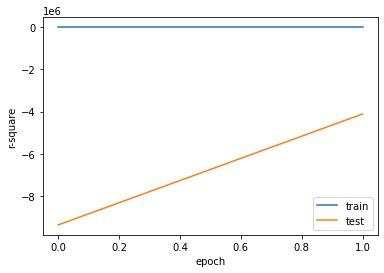

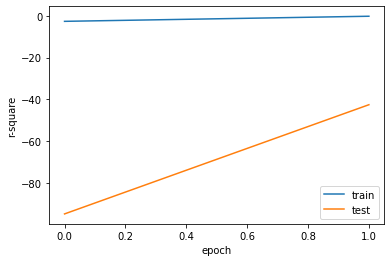

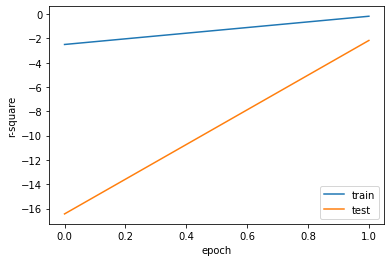

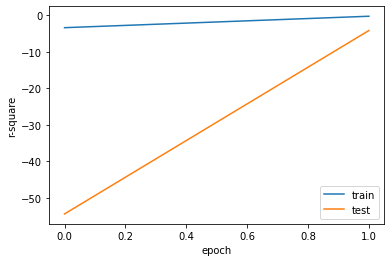

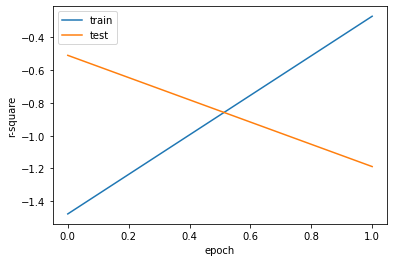

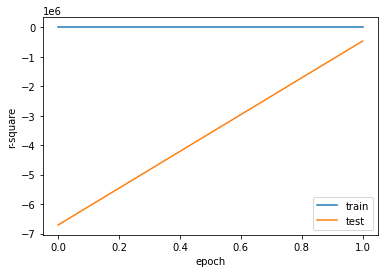

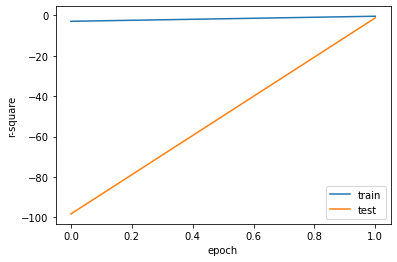

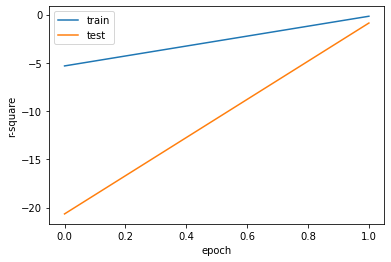

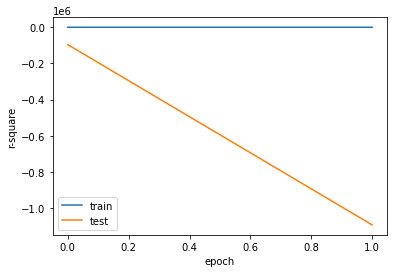

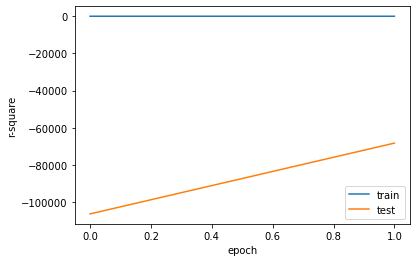

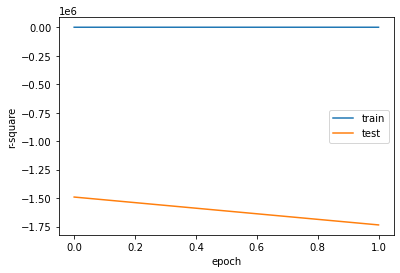

In [20]:
# Leave-One-Stake-Out
i = 1
test_rmse = []
for train_index, test_index in loso.split(X, y, groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = create_loso_model(n_features, final=False)
    es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=1000)
    mc = ModelCheckpoint(path_ann + 'stake_'+str(i)+'_model.h5', monitor='val_loss', mode='min',
                         save_best_only=True, verbose=1)

    history = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                        epochs=2, batch_size = 11, verbose=1, callbacks=[es, mc])

    best_model = load_model(path_ann  + 'stake_'+str(i)+'_model.h5',
                            custom_objects={"r2_keras": r2_keras, 
                                            "r2_keras_loss": r2_keras_loss, 
                                            "root_mean_squared_error": root_mean_squared_error})
    fig, (ax1) = plt.subplots(1,1, figsize=(6,4))
    ax1.plot(history.history['r2_keras'])
    ax1.plot(history.history['val_r2_keras'])
    ax1.set_ylabel('r-square')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='best')
    path_ann_fig + 'stake_'+str(i)+'_model.h5'
    fig.savefig(path_ann_fig + 'stake_'+str(i)+'.png',dpi = 200, bbox_inches = 'tight', 
                 pad_inches = 0.1, facecolor='w')

    score = best_model.evaluate(X_test, y_test)

    test_rmse.append(score[0])

    i= i+1


In [8]:
print(history.history.keys())

dict_keys(['loss', 'r2_keras', 'val_loss', 'val_r2_keras'])


In [10]:
import matplotlib.pyplot as plt

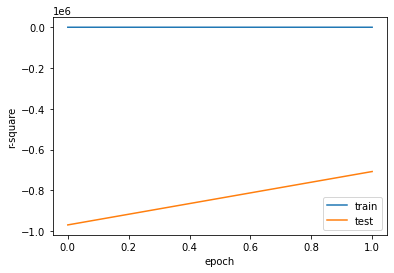

In [17]:
fig, (ax1) = plt.subplots(1,1, figsize=(6,4))
ax1.plot(history.history['r2_keras'])
ax1.plot(history.history['val_r2_keras'])
ax1.set_ylabel('r-square')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'test'], loc='best')
path_ann_fig + 'stake_'+str(i)+'_model.h5'
fig.savefig(path_ann_fig + 'stake_'+str(i)+'.png',dpi = 200, bbox_inches = 'tight', 
             pad_inches = 0.1, facecolor='w')

In [7]:
def run_loso():
    # Leave-One-Stake-Out
    i = 1
    test_rmse = []
    for train_index, test_index in loso.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = create_loso_model(n_features, final=False)
        es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=1000)
        mc = ModelCheckpoint(path_ann + 'stake_'+str(i)+'_model.h5', monitor='val_loss', mode='min',
                             save_best_only=True, verbose=1)

        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                            epochs=3, batch_size = 11, verbose=1, callbacks=[es, mc])

        best_model = load_model(path_ann  + 'stake_'+str(i)+'_model.h5',
                                custom_objects={"r2_keras": r2_keras, 
                                                "r2_keras_loss": r2_keras_loss, 
                                                "root_mean_squared_error": root_mean_squared_error})

        score = best_model.evaluate(X_test, y_test)

        test_rmse.append(score[0])

        i= i+1
    return test_rmse

In [ ]:
x = client.submit(run_loso)
RMSE_r = pd.DataFrame(data={'RMSE': x.result()})
RMSE_r.to_csv('../out/RMSE_ANN_stakes.csv', sep = ' ', index=False)
print(x.result())

In [3]:
df['Year'] = df.index.year

In [4]:
loyo = LeaveOneGroupOut()
groups = df['Year'].values

In [5]:
X = (df.drop(['Diff', 'Event', 'Year'], axis=1)).to_numpy()
y = (df['Diff'].copy()).to_numpy()

In [6]:
x, n_features = X.shape

In [7]:
path_ann = '../ANN/LOYO/CV/'

In [8]:
def run_loyo():
    # Leave-One-Year-Out
    i = 1
    test_rmse = []
    for train_index, test_index in loyo.split(X, y, groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = create_loyo_model(n_features)
        es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=1000)
        mc = ModelCheckpoint(path_ann + 'year_'+str(i)+'_model.h5', monitor='val_loss', mode='min',
                             save_best_only=True, verbose=1)

        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                            epochs=2000, batch_size = 5, verbose=1, callbacks=[es, mc])

        best_model = load_model(path_ann  + 'year_'+str(i)+'_model.h5',
                                custom_objects={"r2_keras": r2_keras, 
                                                "r2_keras_loss": r2_keras_loss, 
                                                "root_mean_squared_error": root_mean_squared_error})

        score = best_model.evaluate(X_test, y_test)

        test_rmse.append(score[0])
        i= i+1
    return test_rmse

In [ ]:
x = client.submit(run_loyo)
RMSE_r = pd.DataFrame(data={'RMSE': x.result()})
RMSE_r.to_csv('../out/RMSE_ANN_years.csv', sep = ' ', index=False)
print(x.result())

In [17]:
X = (df.drop(['Diff', 'Event', 'Year'], axis=1)).to_numpy()
y = (df['Diff'].copy()).to_numpy()

In [18]:
groups = df['Event'].values
years = df.drop_duplicates(subset=['Year'])['Year'].values

In [19]:
x, n_features = X.shape

In [20]:
path_ann = '../ANN/LOYSO/CV/'

In [22]:
def run_loyso():
    # Leave-One-Year-Stake-Out
    i = 1 
    test_rmse = []
    for year, (train_index, test_index) in zip(years, loso.split(X, y, groups)):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = create_lsyso_model(n_features, final=False)
        es = EarlyStopping(monitor='val_loss', mode='min', min_delta=0.01, patience=1000)
        mc = ModelCheckpoint(path_ann + 'year_stake_'+str(i)+'_model.h5', monitor='val_loss', mode='min',
                             save_best_only=True, verbose=1)

        history = model.fit(X_train, y_train, validation_data = (X_test, y_test), 
                            epochs=2000, batch_size = 5, verbose=1, callbacks=[es, mc])

        best_model = load_model(path_ann  + 'year_stake_'+str(i)+'_model.h5',
                                custom_objects={"r2_keras": r2_keras, 
                                                "r2_keras_loss": r2_keras_loss, 
                                                "root_mean_squared_error": root_mean_squared_error})

        score = best_model.evaluate(X_test, y_test)

        test_rmse.append(score[0])
        i= i+1
    return test_rmse

In [25]:
x = client.submit(run_loyso)
RMSE_r = pd.DataFrame(data={'RMSE': x.result()})
RMSE_r.to_csv('../out/RMSE_ANN_years_stakes.csv', sep = ' ', index=False)
print(x.result())